### Use Tensorflow to create progressively more accurate models:
*  Logistic Regression with Gradient Descent
*  Logistic Regression with Stochastic Gradient Descent
*  Neural network with Stochastic Gradient Descent
>* with matrix calculation functions
>* with tf.layers
>* with Keras
*  Logistic Regression with SGD and L2 Regularisation
*  Neural network with SGD and L2 Regularisation
*  Neural network with SGD and Dropout


In [0]:
from __future__ import print_function
import numpy as np
import pickle
import tensorflow as tf

from six.moves import range

### Upload the data file

In [1]:
from google.colab import files
uploaded = files.upload()

Saving notMNISTtiny.pickle to notMNISTtiny.pickle


In [2]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "notMNISTtiny.pickle" with length 502872 bytes


### Load the data

In [0]:
# First reload the data we generated in Assignment 1
pickle_file = '/content/gdrive/My Drive/test/notMNIST.pickle'
#pickle_file = 'notMNISTtiny.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


### Reformat the data for training

In [0]:
# Reformat into a shape that's more adapted to the models we're going to train:
  # data as a flat matrix,
  # labels as float 1-hot encodings

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


### Define a function to calculate accuracy to reuse for all the tests below

In [0]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### Optionally set up Tensorboard and grok for Visualisation

In [0]:
# Set the LOGDIR correctly to use Tensorboard
LOG_DIR = 'tbtry'

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://83bacc8c.ngrok.io


### Now use Tensorflow to create a Logistic Regression model

First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

    with graph.as_default():
    ...

Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

    with tf.Session(graph=graph) as session:

In [0]:
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [0]:
num_steps = 801

with tf.Session(graph=graph) as session:
  #writer = tf.summary.FileWriter(LOG_DIR, session.graph)
  
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 20.448238
Training accuracy: 9.9%
Validation accuracy: 12.0%
Loss at step 100: 2.338470
Training accuracy: 71.9%
Validation accuracy: 71.5%
Loss at step 200: 1.875823
Training accuracy: 75.4%
Validation accuracy: 74.4%
Loss at step 300: 1.618916
Training accuracy: 76.5%
Validation accuracy: 75.2%
Loss at step 400: 1.444717
Training accuracy: 77.5%
Validation accuracy: 75.3%
Loss at step 500: 1.317224
Training accuracy: 78.3%
Validation accuracy: 75.8%
Loss at step 600: 1.218879
Training accuracy: 78.9%
Validation accuracy: 75.9%
Loss at step 700: 1.139847
Training accuracy: 79.6%
Validation accuracy: 76.2%
Loss at step 800: 1.074374
Training accuracy: 80.0%
Validation accuracy: 76.3%
Test accuracy: 83.4%


### Create a Logistic Regression model with Stochastic Gradient Descent

In [0]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

### Create a Logistic Regression model with SGD with a 1-layer Neural Net

In [0]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Weights and Biases for hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))

  # Weights and Biases for output layer
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_train = tf.nn.relu (tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden_train, weights2) + biases2
  
  # Loss and Optimiser
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_valid = tf.nn.relu (tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)

  hidden_test = tf.nn.relu (tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

### Create a Logistic Regression model with SGD with a 1-layer Neural Net using tf.layers

In [0]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Create the hidden and output layers
  hidden = tf.layers.dense(inputs=tf_train_dataset, units=1024, activation=tf.nn.relu)
  logits = tf.layers.dense(inputs=hidden, units=num_labels)
  
  # Compute loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  #valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  #test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

### Create a Logistic Regression model with SGD with a 1-layer Neural Net using Keras

In [0]:
from tensorflow import keras

# Nodes in hidden layer
hidden_size = 1024

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu),
  tf.keras.layers.Dense(num_labels, activation=tf.nn.softmax)
])
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_dataset, train_labels, epochs=20)
model.evaluate(valid_dataset, valid_labels)

Epoch 1/20
100/100 [==============================] - 0s 3ms/step - loss: 2.3777 - acc: 0.1500
Epoch 2/20
100/100 [==============================] - 0s 391us/step - loss: 2.2302 - acc: 0.2200
Epoch 3/20
100/100 [==============================] - 0s 384us/step - loss: 2.0815 - acc: 0.3100
Epoch 4/20
100/100 [==============================] - 0s 373us/step - loss: 1.9508 - acc: 0.4700
Epoch 5/20
100/100 [==============================] - 0s 433us/step - loss: 1.8333 - acc: 0.5400
Epoch 6/20
100/100 [==============================] - 0s 373us/step - loss: 1.7267 - acc: 0.6000
Epoch 7/20
100/100 [==============================] - 0s 385us/step - loss: 1.6209 - acc: 0.8000
Epoch 8/20
100/100 [==============================] - 0s 399us/step - loss: 1.5270 - acc: 0.8100
Epoch 9/20
100/100 [==============================] - 0s 386us/step - loss: 1.4464 - acc: 0.7800
Epoch 10/20
100/100 [==============================] - 0s 400us/step - loss: 1.3749 - acc: 0.7700
Epoch 11/20
100/100 [==========

[1.634765863418579, 0.4000000059604645]

### Add L2 Regularization to the Logistic Regression with SGD (above)

In [0]:
batch_size = 128
beta = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Add the L2 Regularisation
  loss += beta * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

There is an alternate method to add regularisation as discussed [here](https://stackoverflow.com/questions/37107223/how-to-add-regularizations-in-tensorflow). See the answer by bluenote there.

It involves adding the regularisation factor to each Variable when it is created. This allows per-variable customisation of that parameter. Then finally, you use a collection to get all the variables with regularisation added, and compute the loss on it.

In [0]:
# Define a regularizer. This is where the regularization constant can be set, e.g.:
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

# Create variables via:
    weights = tf.get_variable(
        name="weights",
        regularizer=regularizer,
        ...
    )

# The above variables get automatically added to this collection when they
# are created. Get all those variables from the collection here.
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

# Define some loss term and add the regularization term:
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss += reg_term

### Add L2 Regularisation to the Neural Network (above)

In [0]:
batch_size = 128
hidden_size = 1024
beta = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Weights and Biases for hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))

  # Weights and Biases for output layer
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_train = tf.nn.relu (tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden_train, weights2) + biases2
  
  # Loss and Optimiser, with L2 regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  loss += beta * tf.nn.l2_loss(weights1) + beta * tf.nn.l2_loss(weights1)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_valid = tf.nn.relu (tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)

  hidden_test = tf.nn.relu (tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

### Add Dropout to the Neural Network



Normally, when using Dropout, we have to make sure that Dropout is applied only during training and not during testing. So we have to make an adjustment to the Dropout Rate during testing. 

However, note that below, the implementation of dropout is very simple because the code for the training graph is not being fully re-used during testing to calculate the valid_prediction and test_prediction. We are re-calculating the valid_prediction and test_prediction from scratch using the same formulae. So introducing dropout in the training code does not affect the testing calculations (for valid_prediction and test_prediction)



In [0]:
batch_size = 128
hidden_size = 1024
beta = 0.005
drop_rate = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Weights and Biases for hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))

  # Weights and Biases for output layer
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation, with a dropout on the hidden layer
  hidden_train = tf.nn.relu (tf.matmul(tf_train_dataset, weights1) + biases1)
  drop_hidden = tf.nn.dropout (hidden_train, drop_rate)
  logits = tf.matmul(drop_hidden, weights2) + biases2
  
  # Loss and Optimiser, with L2 regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  loss += beta * tf.nn.l2_loss(weights1) + beta * tf.nn.l2_loss(weights1)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_valid = tf.nn.relu (tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)

  hidden_test = tf.nn.relu (tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

### Add Dropout to Neural Network - toggle keep_prob for training and testing

See the comments about the previous implementation regarding the Drop Rate.

A much better implementation below is to re-use the same graph for both training and testing, and pass in a different Drop Rate parameter in each case. In that case we would make drop_rate a placeholder and pass in a different value during training and during testing via feed_dict. See [this](https://stackoverflow.com/questions/44971349/how-to-turn-off-dropout-for-testing-in-tensorflow) and [this](https://stackoverflow.com/questions/40879504/how-to-apply-drop-out-in-tensorflow-to-improve-the-accuracy-of-neural-network).

In [0]:
batch_size = 128
hidden_size = 1024
BETA = 0.001
DROP_RATE = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  X = tf.placeholder(tf.float32,shape=(None, image_size * image_size))
  y = tf.placeholder(tf.float32, shape=(None, num_labels))
  
  # Beta rate for regularisation
  beta_regul = tf.placeholder_with_default(BETA, shape=())
  
  # Set the default value to 1.0. We use this value for all evaluation with
  # the test and validation data, so it doesn't need to passed in via feed_dict
  # Only during training we pass in a different DROP_RATE value via feed_dict
  keep_prob = tf.placeholder_with_default(1.0, shape=())
  
  # Weights and Biases for hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))

  # Weights and Biases for output layer
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation, with a dropout on the hidden layer
  hidden_train = tf.nn.relu (tf.matmul(X, weights1) + biases1)
  drop_hidden = tf.nn.dropout (hidden_train, keep_prob)
  logits = tf.matmul(drop_hidden, weights2) + biases2
  
  # Loss and Optimiser, with L2 regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
  loss += beta_regul * tf.nn.l2_loss(weights1) + beta_regul * tf.nn.l2_loss(weights1)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  prediction = tf.nn.softmax(logits)

In [0]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")

  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {X : batch_data, y : batch_labels, keep_prob: DROP_RATE}
    _, l, train_predictions = session.run(
      [optimizer, loss, prediction], feed_dict=feed_dict)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(train_predictions, batch_labels))
      
      valid_feed_dict = {X : valid_dataset, y : valid_labels}
      valid_predictions = session.run(prediction, feed_dict=valid_feed_dict)
      print("Validation accuracy: %.1f%%" % accuracy(valid_predictions, valid_labels))

  test_feed_dict = {X : test_dataset, y : test_labels}
  test_predictions = session.run(prediction, feed_dict=test_feed_dict)
  print("Test accuracy: %.1f%%" % accuracy(test_predictions, test_labels))


### Run the above experiment "Dropout to Neural Network - toggle keep_prob" with different values for the L2 Regularisation hyperparameter beta to find the best one
The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value for this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale).

In [0]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    for step in range(num_steps):

        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {X : batch_data, y : batch_labels, keep_prob: DROP_RATE, 
                     beta_regul : regul}
        _, l, train_predictions = session.run([optimizer, loss, prediction], 
                                              feed_dict=feed_dict)

        if (step % 500 == 0):
           print("Minibatch loss at step %d: %f" % (step, l))
           print("Minibatch accuracy: %.1f%%" % accuracy(train_predictions, 
                                                          batch_labels))
      
           valid_feed_dict = {X : valid_dataset, y : valid_labels}
           valid_predictions = session.run(prediction, 
                                           feed_dict=valid_feed_dict)
           print("Validation accuracy: %.1f%%" % accuracy(valid_predictions, 
                                                          valid_labels))

           test_feed_dict = {X : test_dataset, y : test_labels}
           test_predictions = session.run(prediction, feed_dict=test_feed_dict)
           print("Test accuracy: %.1f%%" % accuracy(test_predictions, test_labels))
    accuracy_val.append(accuracy(test_predictions, test_labels))



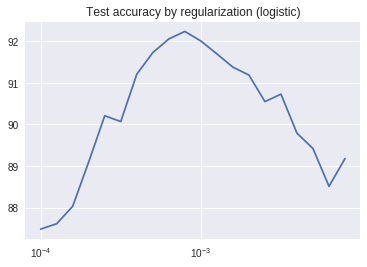

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

### Run the model to train it - reused for all the SGD models above, except Keras

In [0]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")

  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

### Results so far



--- Logistic SGD 
* Minibatch loss at step 3000: 0.646568
* Minibatch accuracy: 83.6%
* Validation accuracy: 79.4%
* Test accuracy: 86.0%

--- Neural Net 1 layer
* Minibatch loss at step 3000: 3.108644
* Minibatch accuracy: 84.4%
* Validation accuracy: 81.5%
* Test accuracy: 87.7%

--- Logistic SGD with L2
* beta = .005
* Minibatch loss at step 3000: 0.512312
* Minibatch accuracy: 86.7%
* Validation accuracy: 82.6%
* Test accuracy: 88.9%

--- Neural Net 1 layer with L2
* beta = .005
* Minibatch loss at step 3000: 0.537447
* Minibatch accuracy: 85.2%
* Validation accuracy: 84.5%
* Test accuracy: 90.5%

--- Neural Net 1 layer with L2 and Dropout
* beta = .005
* drop rate = 0.5
* Minibatch loss at step 2500: 0.734238
* Minibatch accuracy: 78.1%
* Validation accuracy: 83.5%
* Test accuracy: 89.6%

--- Neural Net 1 layer with L2 and Dropout (Alternate)
* beta = .005
* drop rate = 0.5
* Minibatch loss at step 3000: 0.730676
* Minibatch accuracy: 82.8%
* Validation accuracy: 82.8%
* Test accuracy: 89.5%

--- Neural Net 1 layer with L2 and Dropout (Alternate)
* beta = .001
* drop rate = 0.5
* Minibatch loss at step 2500: 4.674984
* Minibatch accuracy: 83.6%
* Validation accuracy: 86.3%
* Test accuracy: 92.3%